In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
drive.mount('/content/gdrive')
from numpy import array
from numpy import asarray
from numpy import zeros

Mounted at /content/gdrive


In [3]:
BATCH_SIZE = 64
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_WORDS_COUNT = 20000
EMBEDDING_SIZE = 100
EPOCHS = 20
LSTM_NODES =256

In [5]:
Input_list = [] 
Output_list = []  
Output_input_list = []  
 
count = 0
for line in open(r'/content/gdrive/My Drive/german_sample.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    Input_list.append(input_sentence)
    Output_list.append(output_sentence)
    Output_input_list.append(output_sentence_input)

print("Number of input samples for encoder:", len(Input_list))
print("Number of output samples for encoder:", len(Output_list))
print("Number of input samples for decoder:", len(Output_input_list))

Number of input samples for encoder: 20000
Number of output samples for encoder: 20000
Number of input samples for decoder: 20000


In [6]:
print(Input_list[150])
print(Output_list[150])
print(Output_input_list[150])

Get Tom.
Hol Tom. <eos>
<sos> Hol Tom.


In [7]:
token_input = Tokenizer(num_words = MAX_WORDS_COUNT)
token_input.fit_on_texts(Input_list)
input_integer_seq = token_input.texts_to_sequences(Input_list)

input_word_index = token_input.word_index
print('Number of unique words in input list: %s' % len(input_word_index))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of the longest sentence in input list: %g" % max_input_len)

Number of unique words in input list: 3552
Length of the longest sentence in input list: 6


In [8]:
token_output = Tokenizer(num_words = MAX_WORDS_COUNT, filters='')
token_output.fit_on_texts(Output_list + Output_input_list)
output_integer_seq = token_output.texts_to_sequences(Output_list)
output_input_integer_seq = token_output.texts_to_sequences(Output_input_list)

output_word_index = token_output.word_index
print('Number of unique words in the output list: %s' % len(output_word_index))

num_words_output = len(output_word_index) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of the longest sentence in output list: %g" % max_out_len)


Number of unique words in the output list: 8090
Length of the longest sentence in output list: 11


In [9]:
encoder_padded_input_sequence = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("Checking shape of padded input sequence for encoder:", encoder_padded_input_sequence.shape)
print("Padded input sequence for encoder at index [150]:", encoder_padded_input_sequence[150])

Checking shape of padded input sequence for encoder: (20000, 6)
Padded input sequence for encoder at index [150]: [ 0  0  0  0 36  1]


In [76]:
print(input_word_index["get"])
print(input_word_index["tom"])

36
1


In [11]:
decoder_padded_input_sequence = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("Checking shape of padded input sequence for decoder:", decoder_padded_input_sequence.shape)
print("Padded input sequence for decoder at index [150]:", decoder_padded_input_sequence[150])

Checking shape of padded input sequence for decoder: (20000, 11)
Padded input sequence for decoder at index [150]: [  2 281  32   0   0   0   0   0   0   0   0]


In [75]:
print(output_word_index["<sos>"])
print(output_word_index["hol"])
print(output_word_index["tom."])

2
281
32


In [13]:
decoder_padded_output_sequence=pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("Checking shape of padded output sequence for decoder:", decoder_padded_output_sequence.shape)
print("Padded output sequence for decoder at index [150]", decoder_padded_output_sequence[150])

Checking shape of padded output sequence for decoder: (20000, 11)
Padded output sequence for decoder at index [150] [281  32   1   0   0   0   0   0   0   0   0]


In [14]:
word_embed_dict = dict()

globvector  = open(r'/content/gdrive/My Drive/glove.6B.100d.txt', encoding="utf8")

for line in globvector:
    records = line.split()
    word = records[0]
    vector_dim  = asarray(records[1:], dtype='float32')
    word_embed_dict[word] = vector_dim 
globvector.close()

In [15]:
words_count = min(MAX_WORDS_COUNT, len(input_word_index) + 1)
embedding_matrix = zeros((words_count, EMBEDDING_SIZE))
for word, index in input_word_index.items():
    embedding_vector = word_embed_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
print(word_embed_dict["get"])

[ 0.14433    0.43951    0.58324   -0.74477   -0.49797    0.086928
 -0.29798    0.39964    0.14083   -0.36578    0.33322    0.47181
  0.1996     0.18278    0.17176   -0.34297    0.04252    0.39309
 -0.66272    0.62738    0.22845    0.44657    0.11174   -0.41396
  0.079795   0.078823  -0.26135   -0.80966    0.52807   -0.47327
  0.055901   0.85753    0.19722    0.30782    0.39039    0.31804
 -0.53604    0.1835     0.081918   0.27753   -0.25792   -0.37158
 -0.2215    -1.0916    -0.52179    0.12665   -0.48591   -0.26716
  0.37119   -1.0525    -0.30202   -0.16279   -0.32528    0.95493
  0.14915   -2.4934     0.27505    0.16308    1.8972     0.21172
  0.10776    1.1318    -0.85962    0.060199   0.83713    0.030006
  0.59344    0.42821   -0.13722   -0.49128    0.0043155 -0.51829
 -0.059878  -0.58476    0.062621   0.31269   -0.52613   -0.35209
 -0.49959   -0.13117    0.62349   -0.092936  -0.92224   -0.32487
 -1.8286    -0.1284     0.50507   -0.034628  -0.79806   -0.49739
 -0.096325  -0.17695   

In [17]:
print(embedding_matrix[36])

[ 0.14432999  0.43950999  0.58323997 -0.74476999 -0.49797001  0.086928
 -0.29798001  0.39963999  0.14083    -0.36578     0.33322001  0.47181001
  0.1996      0.18278     0.17175999 -0.34297001  0.04252     0.39309001
 -0.66272002  0.62738001  0.22845     0.44657001  0.11174    -0.41396001
  0.079795    0.078823   -0.26135001 -0.80966002  0.52806997 -0.47327
  0.055901    0.85753     0.19722     0.30781999  0.39039001  0.31804001
 -0.53604001  0.18350001  0.081918    0.27753001 -0.25792    -0.37158
 -0.22149999 -1.09159994 -0.52179003  0.12665001 -0.48591    -0.26716
  0.37119001 -1.05250001 -0.30202001 -0.16279    -0.32528001  0.95493001
  0.14915    -2.4934001   0.27505001  0.16308001  1.89719999  0.21172
  0.10776     1.13180006 -0.85961998  0.060199    0.83713001  0.030006
  0.59344     0.42820999 -0.13722    -0.49127999  0.0043155  -0.51828998
 -0.059878   -0.58476001  0.062621    0.31268999 -0.52613002 -0.35209
 -0.49959001 -0.13117     0.62348998 -0.092936   -0.92224002 -0.324869

In [18]:
embedding_layer = Embedding(words_count, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [19]:
decoder_target_array = np.zeros((
        len(Input_list),
        max_out_len,
        num_words_output
    ),
    dtype='float32')

In [20]:
decoder_target_array.shape

(20000, 11, 8091)

In [21]:
for i,d in enumerate(decoder_padded_output_sequence):
    for t, word in enumerate(d):
        decoder_target_array[i, t, word] = 1

In [22]:
encoder_in_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_in_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [23]:
decoder_in_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_in_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [24]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [25]:
model1 = Model([encoder_in_placeholder,
  decoder_in_placeholder], decoder_outputs)
model1.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [29]:
r = model1.fit(
    [encoder_padded_input_sequence, decoder_padded_input_sequence],
    decoder_target_array,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,)

Epoch 1/20
282/282 [==============================] - 128s 436ms/step - loss: 2.1484 - accuracy: 0.7047 - val_loss: 2.1425 - val_accuracy: 0.7032
Epoch 2/20
282/282 [==============================] - 117s 415ms/step - loss: 1.5846 - accuracy: 0.7683 - val_loss: 1.8742 - val_accuracy: 0.7417
Epoch 3/20
282/282 [==============================] - 116s 413ms/step - loss: 1.3857 - accuracy: 0.7934 - val_loss: 1.7795 - val_accuracy: 0.7558
Epoch 4/20
282/282 [==============================] - 116s 411ms/step - loss: 1.2575 - accuracy: 0.8105 - val_loss: 1.6865 - val_accuracy: 0.7678
Epoch 5/20
282/282 [==============================] - 115s 407ms/step - loss: 1.1594 - accuracy: 0.8234 - val_loss: 1.6157 - val_accuracy: 0.7734
Epoch 6/20
282/282 [==============================] - 115s 407ms/step - loss: 1.0805 - accuracy: 0.8334 - val_loss: 1.5828 - val_accuracy: 0.7781
Epoch 7/20
282/282 [==============================] - 113s 402ms/step - loss: 1.0122 - accuracy: 0.8428 - val_loss: 1.5399 -

In [30]:
encoder_model = Model(encoder_in_placeholder, encoder_states)

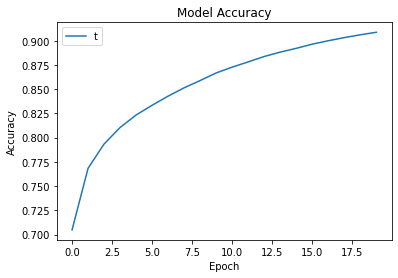

In [47]:
plt.plot(r.history['accuracy'])
plt.title('Tranining Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

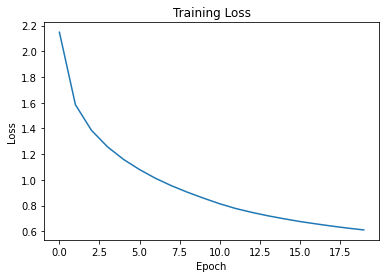

In [52]:
plt.plot(r.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

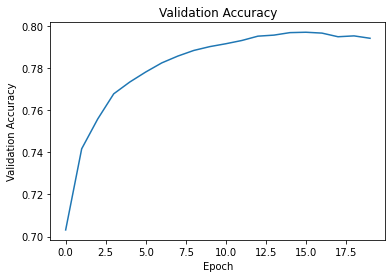

In [53]:
plt.plot(r.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

plt.show()

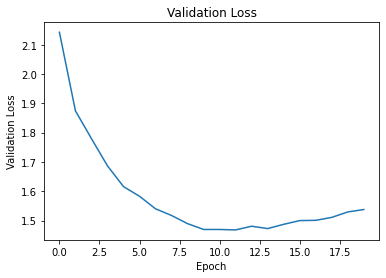

In [54]:
plt.plot(r.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')

plt.show()

In [55]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [56]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [57]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [58]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [59]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [61]:
index_input_word = {v:k for k, v in input_word_index.items()}
index_target_word = {v:k for k, v in output_word_index.items()}

In [62]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_word_index['<sos>']
    eos = output_word_index['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = index_target_word[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [74]:
i = np.random.choice(len(Input_list))
input_seq = encoder_padded_input_sequence[i:i+1]
translation = translate_sentence(input_seq)

print('Randomly chosen input sentence:', Input_list[i])
print('Translated sentence:', translation)



Randomly chosen input sentence: Tom looks awful.
Translated sentence: tom sieht schlecht aus.
